# Project Healthcare PGP

## Author: Jessica Bosch
## Last Update: July 11, 2021

**Problem Statement**
- NIDDK (National Institute of Diabetes and Digestive and Kidney Diseases) research creates knowledge about and treatments for the most chronic, costly, and consequential diseases.
- The dataset used in this project is originally from NIDDK. The objective is to predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.
- Build a model to accurately predict whether the patients in the dataset have diabetes or not.

**Dataset Description**

The datasets consists of several medical predictor variables and one target variable (Outcome). Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and more.
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skinfold thickness (mm)
- Insulin: Two hour serum insulin
- BMI: Body Mass Index
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age in years
- Outcome: Class variable (either 0 or 1). 268 of 768 values are 1, and the others are 0

In [1]:
# for nicer output of large figures/cells
from IPython.core.display import HTML
style = """
<style>
div.output_area {
    overflow-y: scroll;
}
div.output_area img {
    max-width: 1000px;
}
</style>
"""
HTML(style)

#### Import libraries

In [6]:
# import libraries
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import lightgbm as lgb

from scipy.stats import randint, uniform

import shap
import re

#### Load data

In [7]:
df = pd.read_csv('data/health care diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
# size of the data
df.shape

(768, 9)

The dataset is very small: 768 rows and 9 columns.

# 1) Data Exploration

1. Perform descriptive analysis. Understand the variables and their corresponding values. On the columns below, a value of zero does not make sense and thus indicates missing value:
    - Glucose
    - BloodPressure
    - SkinThickness
    - Insulin
    - BMI


2. Visually explore these variables using histograms. Treat the missing values accordingly.


3. There are integer and float data type variables in this dataset. Create a count (frequency) plot describing the data types and the count of variables. 

In [9]:
# get summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- No non-null values.
- 2 variables are of float64 type: BMI and DiabetesPedigreeFunction; the remaining variables are of int64 type.

In [10]:
# view statistics of each numeric variable
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


A value of zero does not make sense for the following variables:
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI

Let's replace those zero values with NaNs (missing values) and explore how many NaNs we have:

In [11]:
print('Number of NaNs and their percentage of the data')

for col in df.columns[1:6]:
    # replace zero values with NaNs
    df[col].replace(0, np.nan, inplace=True)
    # count number of NaNs and get their percentage of the whole data
    print('  {:<15} {:^15} {:.1f}%'.format(col, df[col].isna().sum(), df[col].isna().sum()*100/df.shape[0]))

Number of NaNs and their percentage of the data
  Glucose                5        0.7%
  BloodPressure         35        4.6%
  SkinThickness         227       29.6%
  Insulin               374       48.7%
  BMI                   11        1.4%


Insulin has the highest amount of missing values: 48.7% of data is missing. SkinThickness also has a high amount: 29.6% of data is missing. We cannot simply drop the missing values (since our dataset is very small). Instead, we will apply the KNNImputer which performs imputation for completing missing values using k-Nearest Neighbors.

Before we apply the KNNImputer, let's have a look at the distribution of our data via histogram plots:

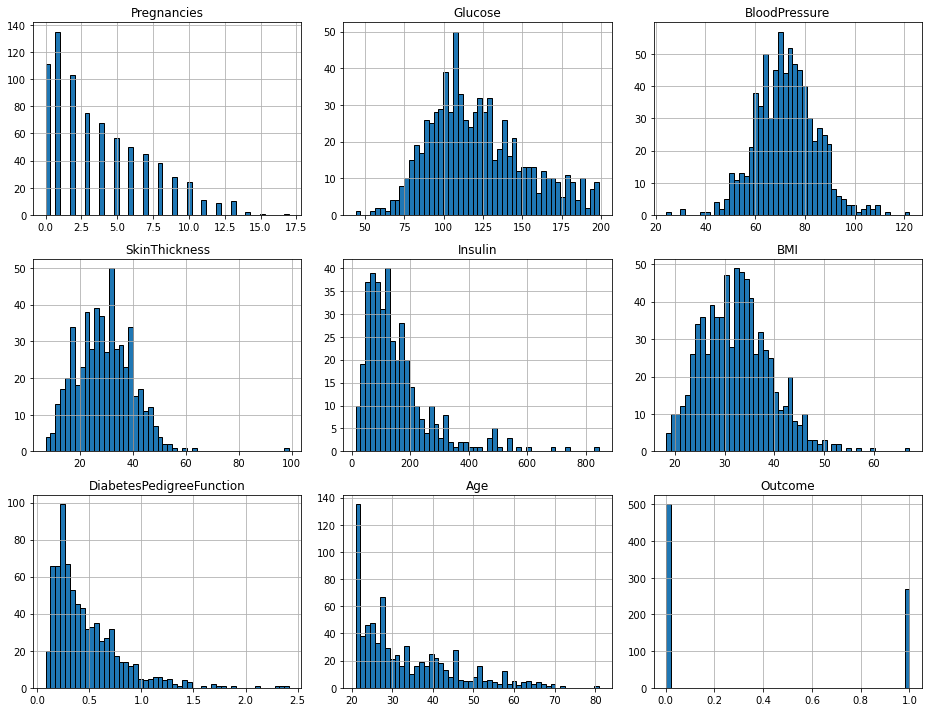

In [8]:
# visualize columns as histograms
df.hist(figsize=(13,10), ec="k", bins=50)
plt.tight_layout()

In [9]:
# get median of each variable
df.median()

Pregnancies                   3.0000
Glucose                     117.0000
BloodPressure                72.0000
SkinThickness                29.0000
Insulin                     125.0000
BMI                          32.3000
DiabetesPedigreeFunction      0.3725
Age                          29.0000
Outcome                       0.0000
dtype: float64

## 1.1) Missing value Treatment

Let's apply the KNNImputer:

In [10]:
# copy dataframe
df_clean = df.copy()

# initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

# impute/fill missing values
df_clean[:] = imputer.fit_transform(df)
df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [11]:
# data type of each column
df_clean.dtypes

Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Outcome                     float64
dtype: object

All columns are of type float64. We will transform them back to int64 types (except for BMI and DiabetesPedigreeFunction):

In [12]:
# transform variables back to int64 types (except BMI and DiabetesPedigreeFunction)
for col in ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','Age','Outcome']:
    df_clean[col] = df_clean[col].astype(np.int64)
df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,169,33.6,0.627,50,1
1,1,85,66,29,58,26.6,0.351,31,0
2,8,183,64,25,164,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [13]:
# confirm data type of each column
df_clean.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [14]:
# view statistics of each numeric variable
df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.593750,72.352865,28.993490,152.989583,32.427344,0.471876,33.240885,0.348958
std,3.369578,30.498792,12.205401,9.426098,98.383982,6.886588,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,23.000000,87.750000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,133.500000,32.090000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,35.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


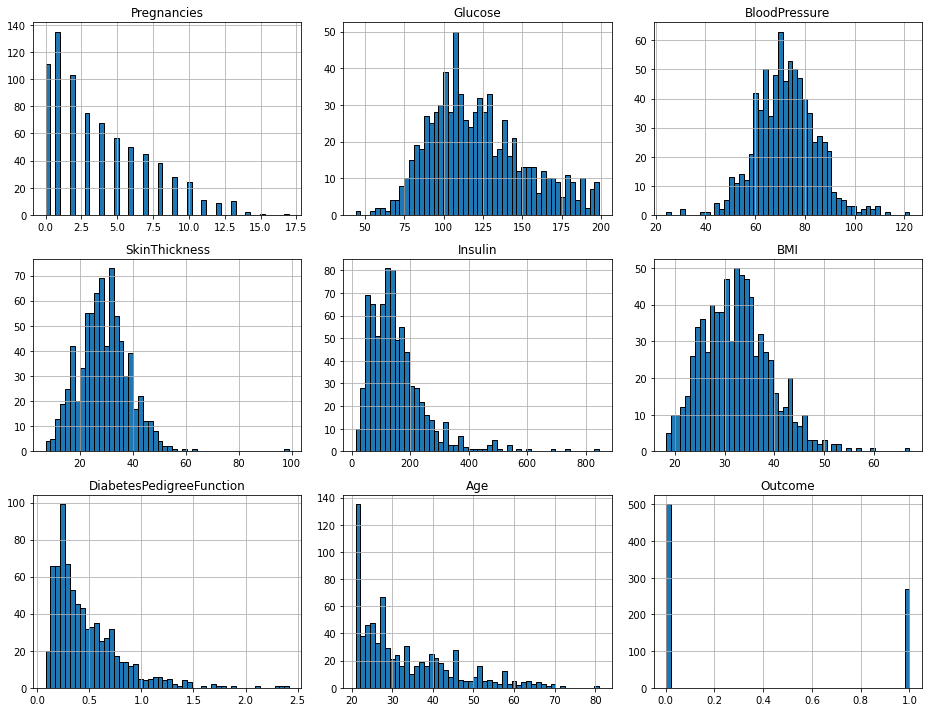

In [15]:
# visualize columns as histograms
df_clean.hist(figsize=(13,10), ec="k", bins=50)
plt.tight_layout()

In [16]:
# get median of each variable
df_clean.median()

Pregnancies                   3.0000
Glucose                     117.0000
BloodPressure                72.0000
SkinThickness                29.0000
Insulin                     133.5000
BMI                          32.0900
DiabetesPedigreeFunction      0.3725
Age                          29.0000
Outcome                       0.0000
dtype: float64

After imputing the missing values, the statistics for Glucose, BloodPressure, SkinThickness, Insulin, and BMI remain mostly close to the statistics of the original data:
- The max values stay the same.
- The min values have increased.
- For Glucose: the lower, 50 and upper percentiles stay the same.
- For BloodPressure: the 50 and upper percentiles stay the same; the lower percentile has increased slightly.
- For BMI: the upper percentile stays the same; the lower and 50 percentiles have increased slightly.
- Both SkinThickness and Insulin had a high amount of missing data, so the percentiles have changed to a relative larger amount. However, the median stays the same for SkinThickness and stays close for Insulin.

## 1.2) Outlier Treatment

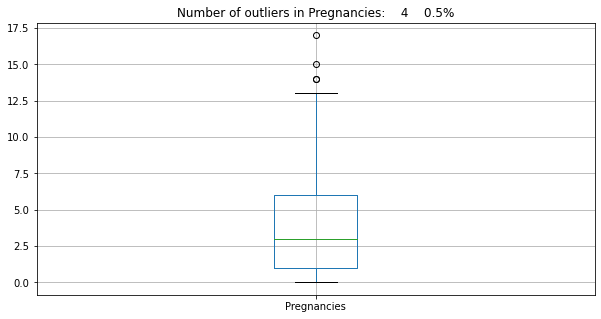

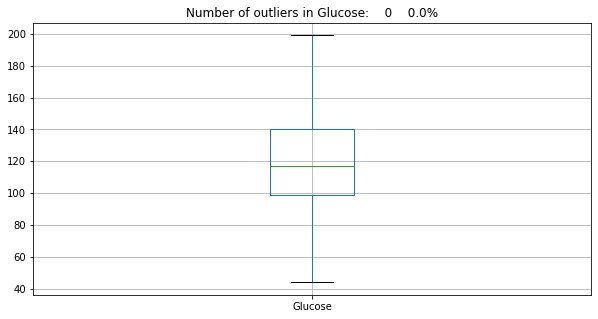

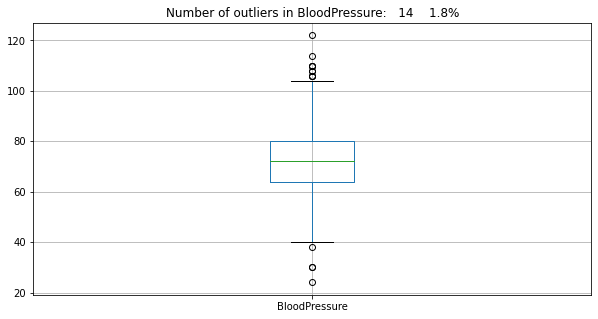

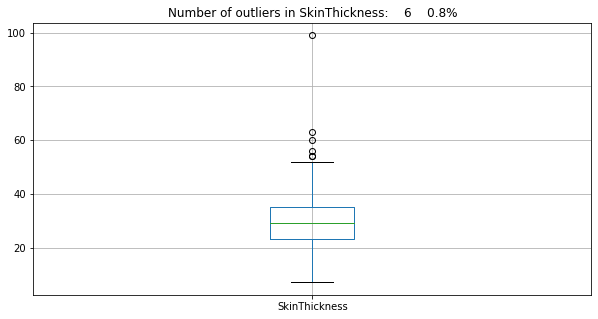

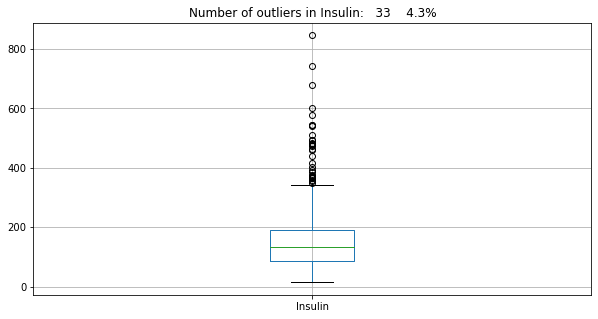

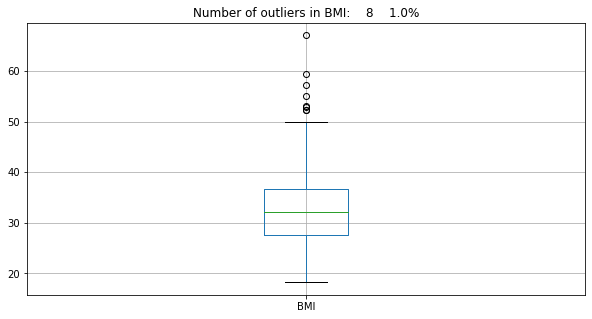

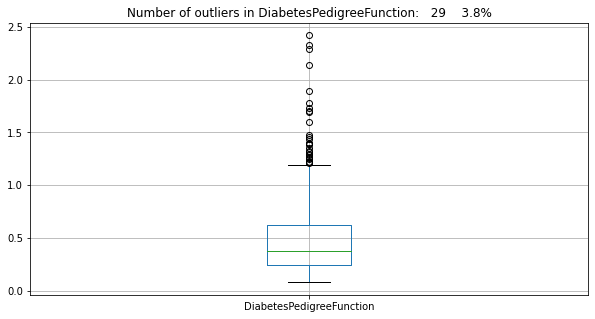

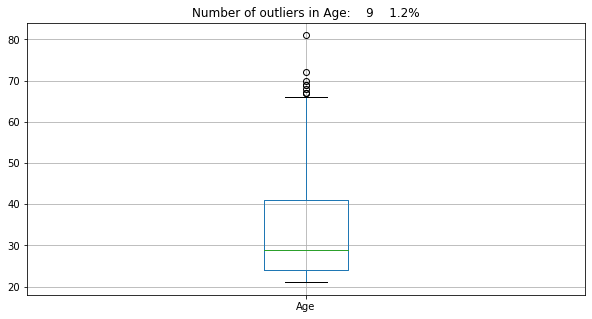

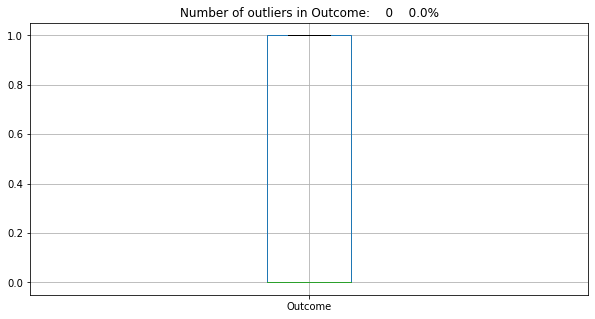

In [17]:
# check for outliers via quantile function
Q1 = df_clean.quantile(0.25)
Q3 = df_clean.quantile(0.75)
IQR = Q3 - Q1

# create boxplot for each column
for col in df_clean:
    plt.figure()
    df_clean.boxplot(column=[col])
    outliers = ((df_clean[col] < (Q1[col] - 1.5 * IQR[col])) | (df_clean[col] > (Q3[col] + 1.5 * IQR[col]))).sum()
    # count number of outliers and get their percentage of the whole data
    plt.title('Number of outliers in {}: {:^7} {:.1f}%'.format(col, outliers, outliers*100/df_clean.shape[0]))

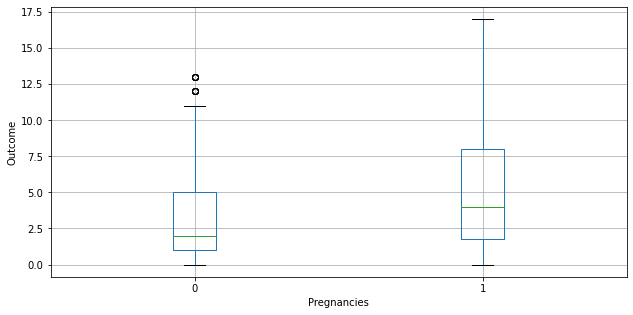

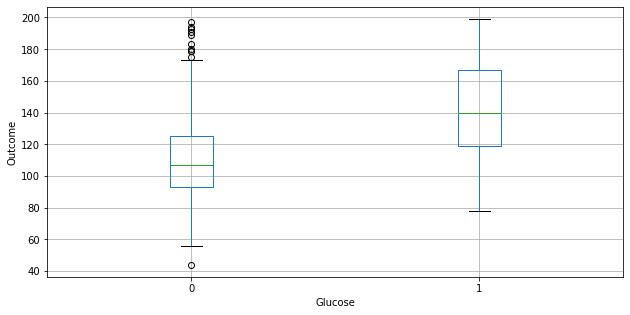

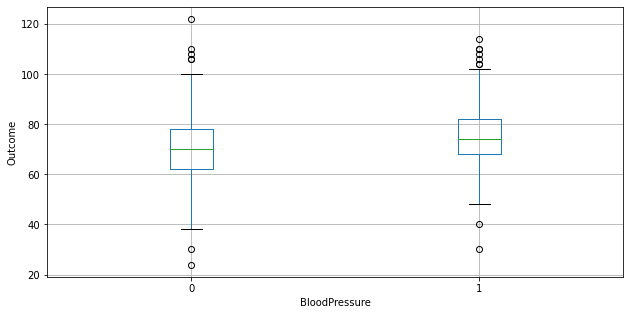

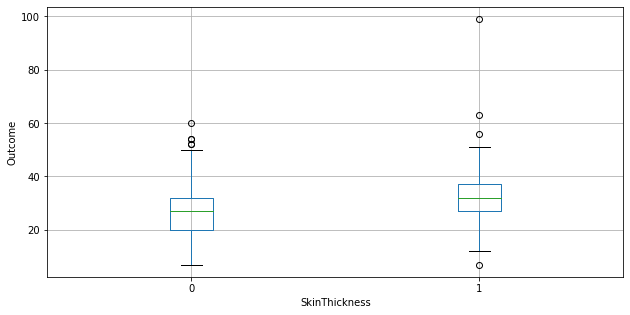

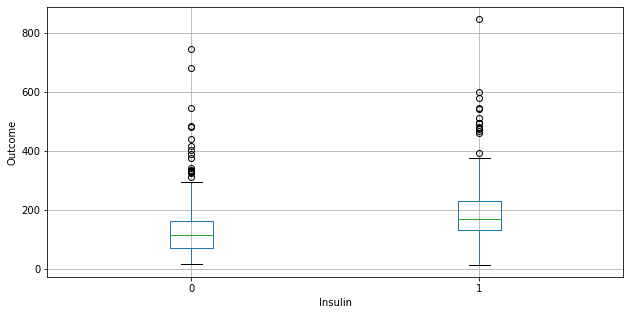

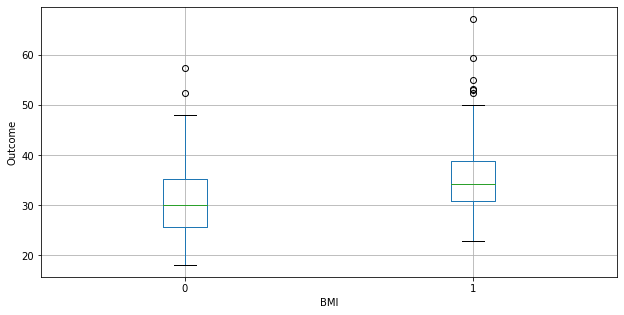

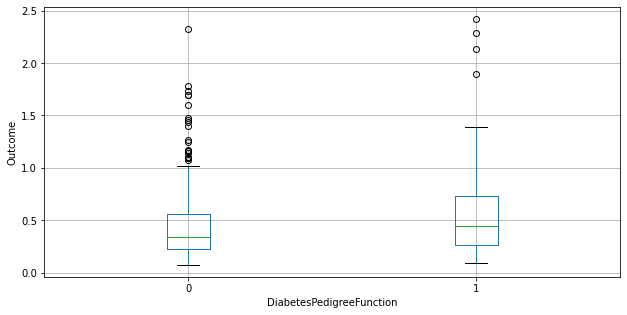

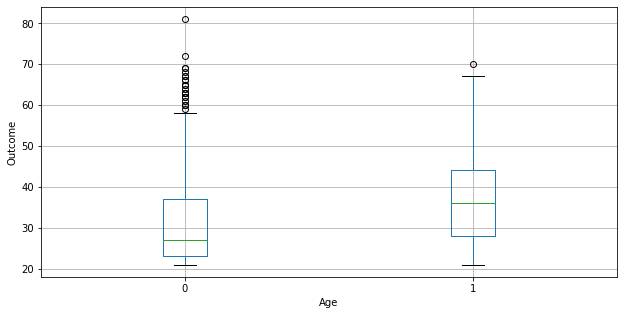

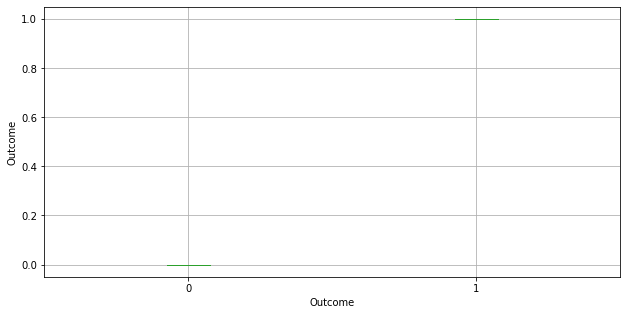

In [18]:
# create boxplot for each column, separated between the two Outcome values
for col in df_clean:
    ax = df_clean.boxplot(by='Outcome', column=col)
    ax.set_xlabel(col)
    ax.set_ylabel('Outcome')
    plt.title('')
    plt.suptitle('')

In [19]:
print('Total number of outliers is {} and its percentage is {:.1f}%.'.
      format(sum(((df_clean < (Q1 - 1.5 * IQR)) | (df_clean > (Q3 + 1.5 * IQR))).sum()), 
             sum(((df_clean < (Q1 - 1.5 * IQR)) | (df_clean > (Q3 + 1.5 * IQR))).sum())*100/df_clean.shape[0]))

Total number of outliers is 103 and its percentage is 13.4%.


The percentage of outliers in each column is below 4.4%. The total number of outliers is 103, which is 13.4% of the data. Since our dataset is very small, we will not remove all outliers.

We will remove the outliers from the following columns:
- Pregnancies: more than 13 pregnancies
- BloodPressure: values above 120 (hypertensis crisis) and below 35
- SkinThickness: values above 59
- Insulin: values above 600
- BMI: values above 60
- DiabetesPedigreeFunction: values above 2.0
- Age: values above 70

In [20]:
# outlier filter
outlier_filter = (df_clean['Pregnancies'].values <= 13) & \
                 (df_clean['BloodPressure'].values >= 35) & \
                 (df_clean['BloodPressure'].values <= 120) & \
                 (df_clean['SkinThickness'].values <= 59) & \
                 (df_clean['Insulin'].values <= 600) & \
                 (df_clean['BMI'].values <= 54) & \
                 (df_clean['DiabetesPedigreeFunction'].values <= 2.0) & \
                 (df_clean['Age'].values <= 70)

# apply filter to dataframe
df_clean = df_clean[outlier_filter]
df_clean.shape

(748, 9)

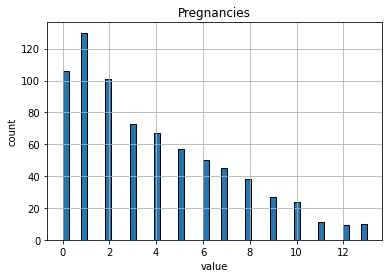

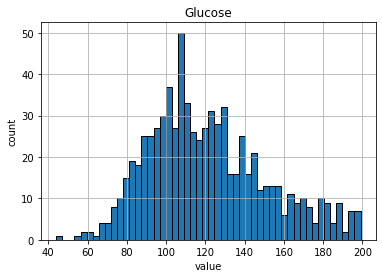

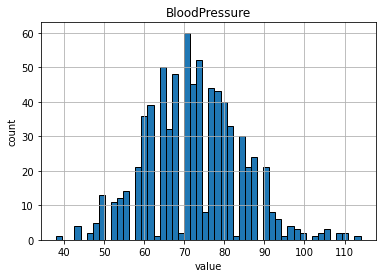

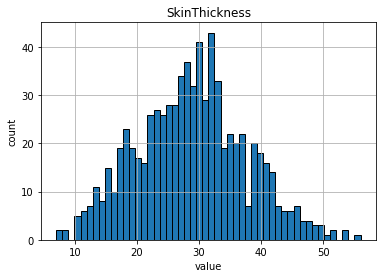

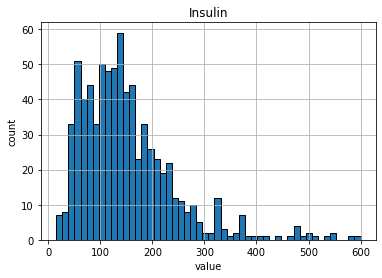

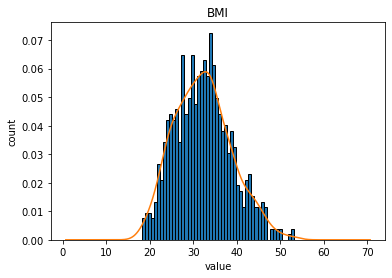

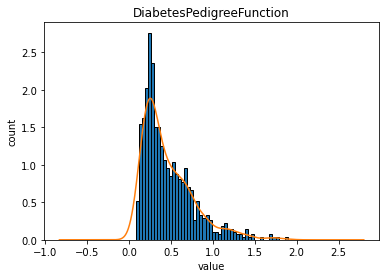

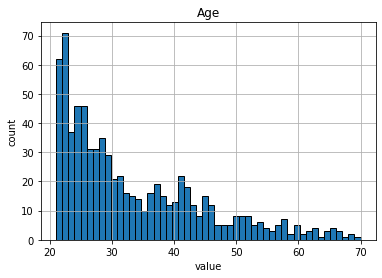

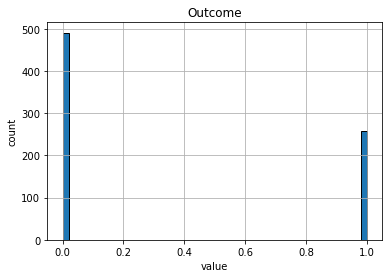

In [21]:
# visualize integer columns as histograms and float columns as density functions
for col in df_clean.columns:
    if (df_clean[col].dtype=='int64'):
        plt.figure()
        df_clean[col].hist(figsize=(6,4), ec="k", bins=50)
    else:
        plt.figure()
        df_clean[col].hist(figsize=(6,4), ec="k", bins=50, density=True, stacked=True)
        df_clean[col].plot(kind='density')
    plt.title(col)
    plt.xlabel('value')
    plt.ylabel('count')

<br>

# 2) Data Exploration

1. Check the balance of the data by plotting the count of outcomes by their value. Describe your findings and plan future course of action.


2. Create scatter charts between the pair of variables to understand the relationships. Describe your findings.


3. Perform correlation analysis. Visually explore it using a heat map.

In [22]:
# count of Outcome values in percentage
df_clean.groupby(['Outcome']).size()*100/df_clean.shape[0]

Outcome
0    65.641711
1    34.358289
dtype: float64

<AxesSubplot:xlabel='Outcome', ylabel='count'>

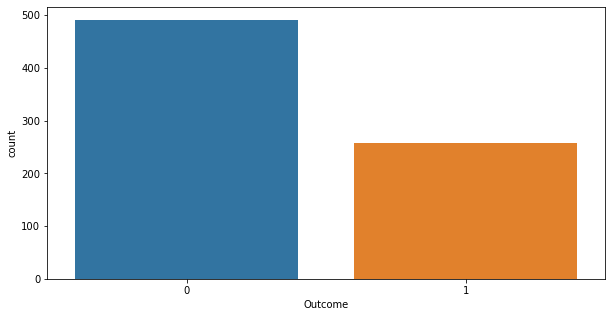

In [23]:
# plot count of Outcome values
sns.countplot(x=df_clean['Outcome'])

66% of the data belongs to Outcome class 0, while 34% belongs to class 1. The result Outcome is unbalanced with more values of class 0. So, this is an unbalanced binary classification problem.

To address this problem, in the next section we will use the Synthetic Minority Oversampling Technique (SMOTE) to remove the imbalance in the training data by oversampling the minority class.

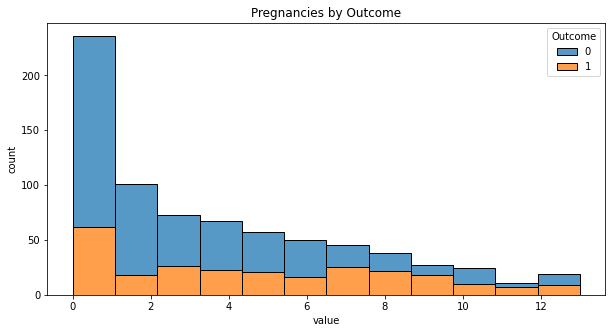

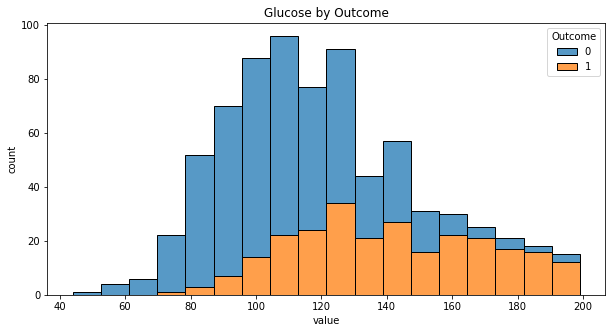

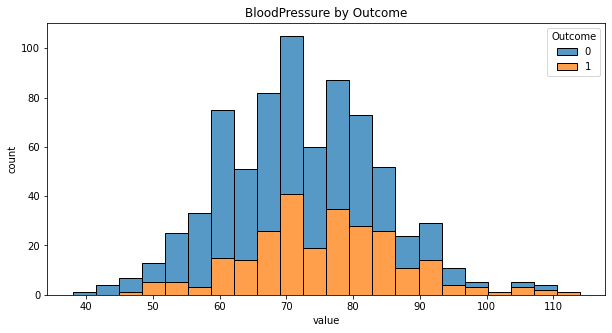

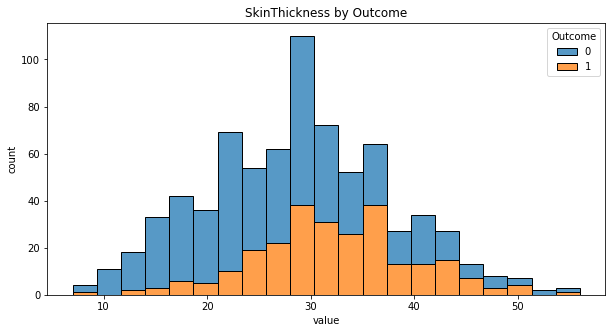

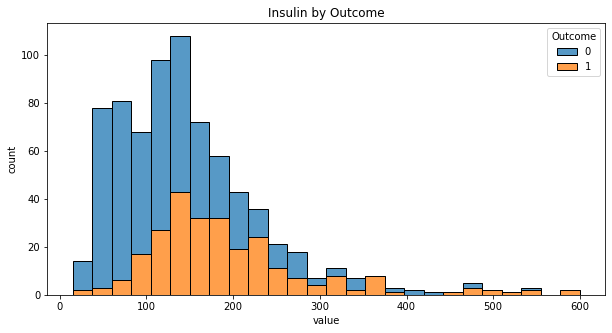

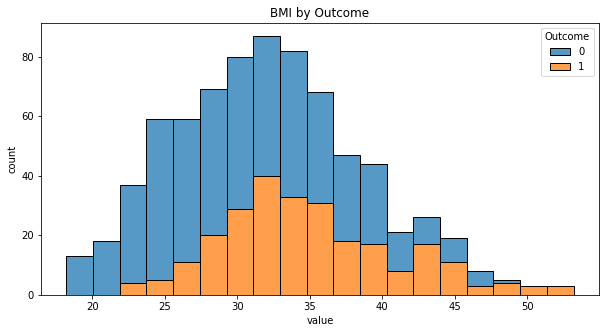

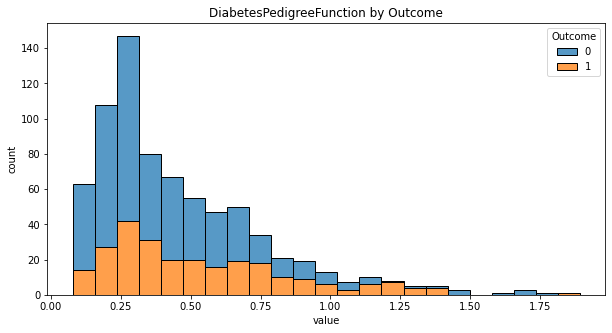

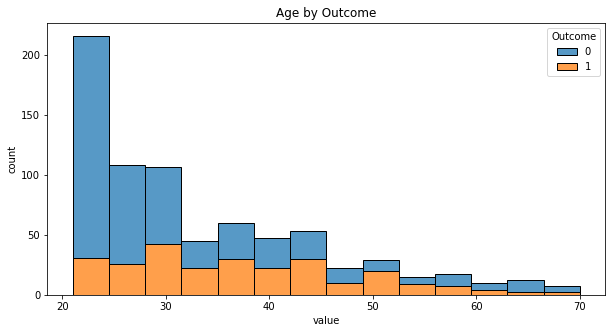

In [24]:
# histogram of each column, color-coded by Outcome
for col in df_clean.columns[:-1]:
    plt.figure()
    sns.histplot(data=df_clean, x=col, hue="Outcome", multiple="stack")
    plt.title('{} by Outcome'.format(col))
    plt.xlabel('value')
    plt.ylabel('count')

In our data, some variable ranges are only represented by one Outcome class:
- Glucose values below 70 are all of class 0
- BloodPressure values below 45 are all of class 0, and values above 111 are all of class 1
- Insulin values above ~550 are all of class 1
- BMI values below ~22 are all of class 0, and values above ~50 are all of class 1

These are all extreme values, meaning they are located around minimum or maximum value of a variable.
- This could mean that these extreme values indicate the class outcome with 100% (for instance, if the Glucose value is below 70, then the class is 0).
- Or this could mean that we don't have enough data representing these extreme cases (no data for the second class).
- We may have removed data representing these extreme cases during our outlier treatment above.

In [25]:
# mean value of each variable, grouped by Outcome
df_clean.groupby(['Outcome']).mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.315682,110.262729,70.692464,26.938900,127.723014,30.734868,0.423682,31.067210
1,4.813230,141.836576,75.583658,32.105058,194.295720,35.040000,0.534268,36.980545


In [26]:
# median value of each variable, grouped by Outcome
df_clean.groupby(['Outcome']).median()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,2,107,70,27,113,30.1,0.332,27
1,4,140,75,32,171,34.2,0.447,36


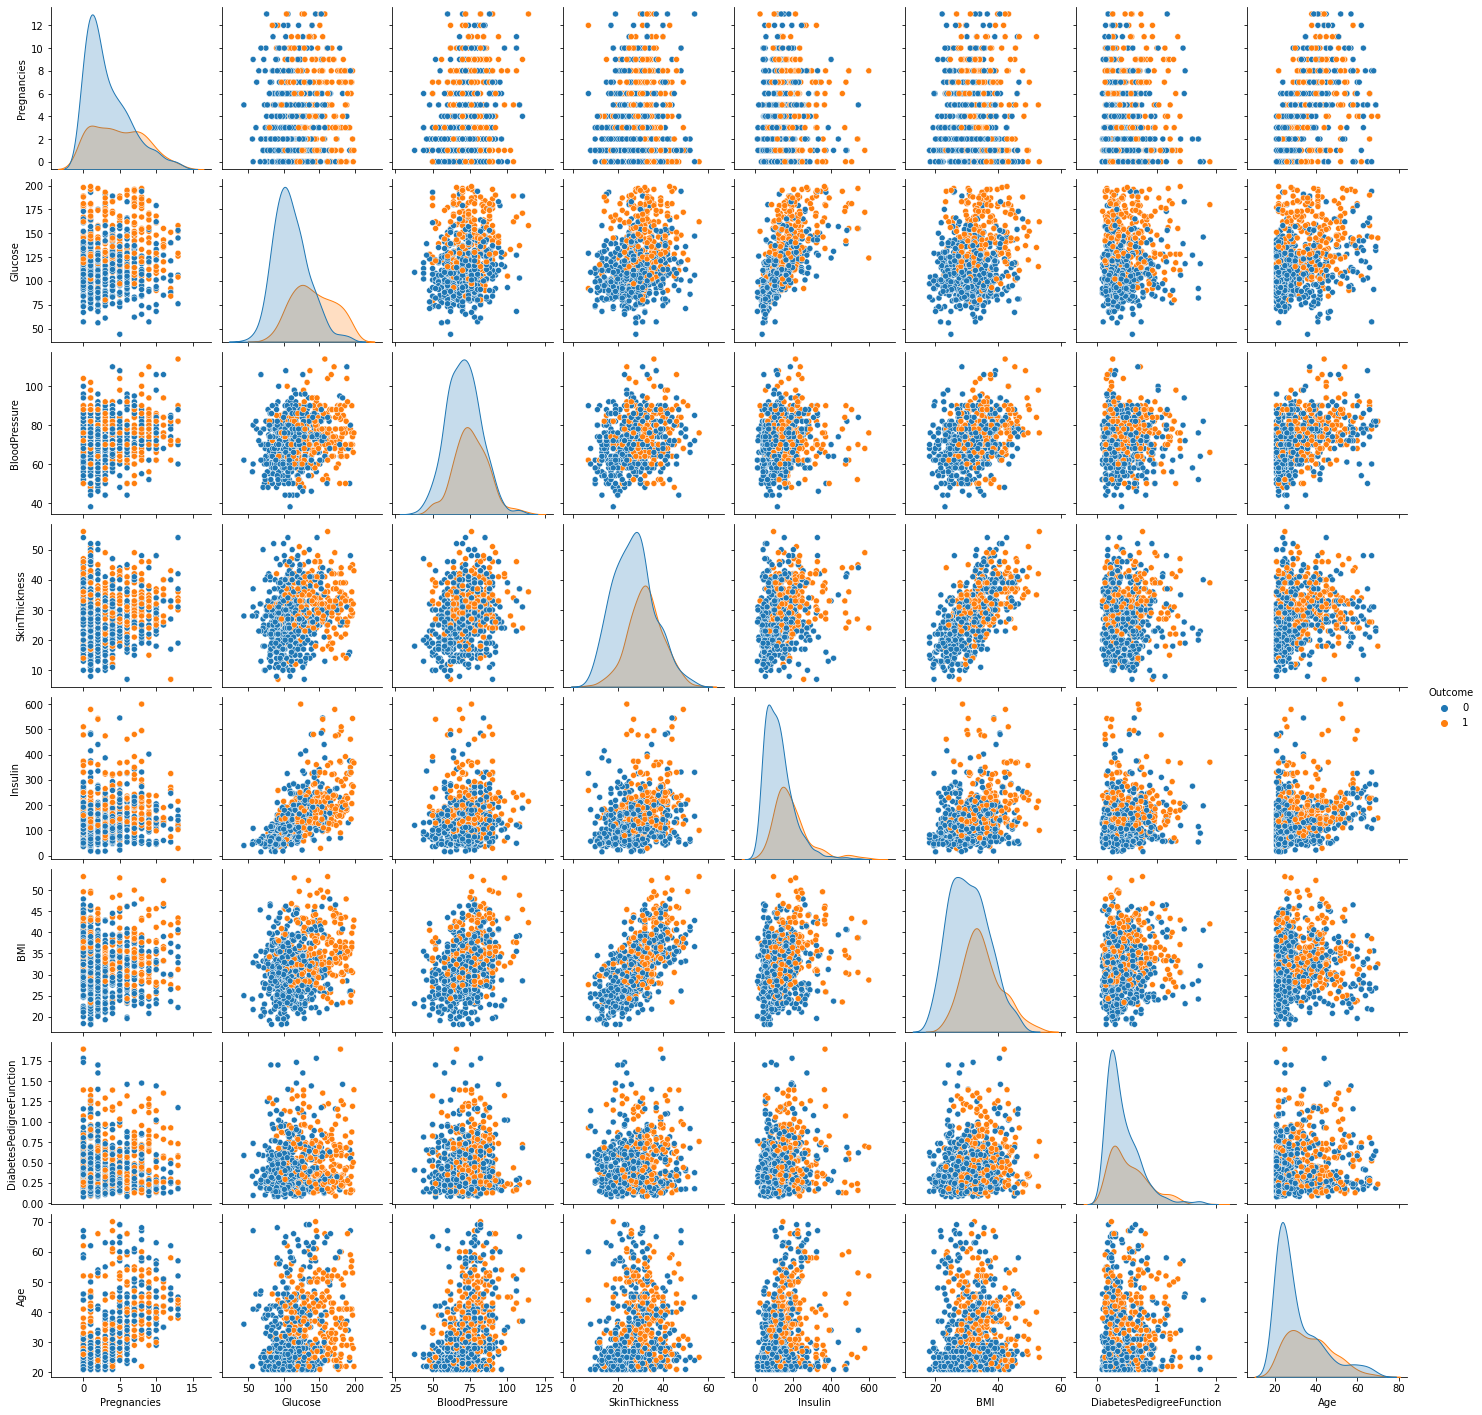

In [27]:
# scatter plots between pairs of variables, color-coded by Outcome
sns.pairplot(df_clean, hue='Outcome')

Outcome 0 clusters:
- Pregnancies below 4
- Glucose between 70 and 150
- BloodPressure between 58 and 85
- SkinThickness between 10 and 40
- Insulin between 25 and 200
- BMI between 20 and 40
- DiabetesPedigreeFunction below 0.75
- Age below 32

Outcome 1 clusters:
- Glucose above 120
- BloodPressure between 65 to 65
- SkinThickness between 25 to 38
- Insulin between 100 and 250
- BMI between 28 and 40
- DiabetesPedigreeFunction below 0.75

This suggests that Outcome 0 is more likely among lower Pregnancies, Glucose, SkinThickness, Insulin, BMI, and Age values; whereas Outcome 1 is more likely when most of those variables show higher values.

In [28]:
# pairwise correlation between variables
df_corr = df_clean.corr()
df_corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.130934,0.241008,0.125351,0.088168,0.043079,-0.013400,0.558678,0.216717
Glucose,0.130934,1.000000,0.247977,0.225763,0.640676,0.239611,0.103664,0.268601,0.497289
BloodPressure,0.241008,0.247977,1.000000,0.249582,0.144152,0.322690,0.016313,0.372525,0.199350
SkinThickness,0.125351,0.225763,0.249582,1.000000,0.267495,0.657599,0.064760,0.144409,0.274847
Insulin,0.088168,0.640676,0.144152,0.267495,1.000000,0.274115,0.101359,0.251076,0.349749
BMI,0.043079,0.239611,0.322690,0.657599,0.274115,1.000000,0.115796,0.062193,0.312861
DiabetesPedigreeFunction,-0.013400,0.103664,0.016313,0.064760,0.101359,0.115796,1.000000,0.046701,0.171951
Age,0.558678,0.268601,0.372525,0.144409,0.251076,0.062193,0.046701,1.000000,0.243306
Outcome,0.216717,0.497289,0.199350,0.274847,0.349749,0.312861,0.171951,0.243306,1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'Pregnancies'),
  Text(1.5, 0, 'Glucose'),
  Text(2.5, 0, 'BloodPressure'),
  Text(3.5, 0, 'SkinThickness'),
  Text(4.5, 0, 'Insulin'),
  Text(5.5, 0, 'BMI'),
  Text(6.5, 0, 'DiabetesPedigreeFunction'),
  Text(7.5, 0, 'Age'),
  Text(8.5, 0, 'Outcome')])

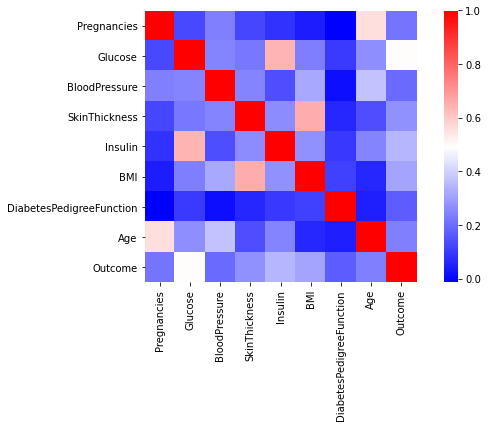

In [29]:
# pairwise correlation via heatmap
sns.heatmap(data = df_corr, square = True, cmap = "bwr")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Above shows the Pearson's correlation, which measures the linear association between the variables.

There is no strong correlation between the variables.

Moderate correlation (0.5 to 0.7) between:

    - SkinThickness and BMI (0.657599)
    - Glucose and Insulin (0.640676)
    - Pregnancies and Age (0.558678)
    
Weak correlation (0.3 to 0.5) between:

    - Glucose and Outcome (0.497289)
    - Age and BloodPressure (0.372525)
    - Insulin and Outcome (0.349749)
    - BMI and BloodPressure (0.322690)
    - BMI and Outcome (0.312861)
    
Negligible correlation between the remaining variable pairs.

Outcome is weakly correlated with Glucose, Insulin, and BMI.

<br>

# 3) Data Modeling

1. Devise strategies for model building. It is important to decide the right validation framework. Express your thought process.


2. Apply an appropriate classification algorithm to build a model.


3. Compare various models with the results from KNN algorithm.


4. Create a classification report by analyzing sensitivity, specificity, AUC (ROC curve), etc. Please be descriptive to explain what values of these parameter you have used.

In [30]:
# extract values from dataframe
array = df_clean.values

# extract feature values
X = array[:,0:8]

# extract target values
Y = array[:,8].astype(int)

In [31]:
# split dataset into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [32]:
# sizes of training and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(598, 8)
(150, 8)
(598,)
(150,)


Before building a classification model, we apply a scaler to our feature variables. Since we did not remove all outliers from the data, we will use the RobustScaler to scale our features using statistics that are robust to outliers.

Also, we use the Borderline Synthetic Minority Oversampling Technique (Borderline-SMOTE) to remove the imbalance in the training data by oversampling the minority class: we oversample those instances of the minority class that are misclassified.

We create these two objects here, and later we will use them in a pipeline together with a classification model.

In [33]:
# feature scaling object
transformer = RobustScaler()

# Borderline-SMOTE2 object
smt = BorderlineSMOTE(random_state=7, kind='borderline-2', n_jobs=4)

Now, we will look at different classification models.

We will evaluate the models using the ROC area under curve (AUC) metric. Once we have selected the "best" models using this metric, we will also compare the models by other classification metrics.

## 3.1) LGBMClassifier

### 3.1.1) Hyperparameter Optimization

Our first classification algorithm is LightGBM. The LGBMClassifier is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms.

Since the model has a lot of parameters to be set, we start with hyperparameter optimization: we apply a randomized search on hyperparameters.

In [34]:
# parameters to pass to the fit method
lgb_fit_params = {'lgb_tune__early_stopping_rounds': 30,
                  'lgb_tune__eval_metric': 'binary', 
                  'lgb_tune__eval_set': [(X_test,y_test)],
                  'lgb_tune__eval_names': ['valid'],
                  'lgb_tune__verbose': 100}

In [35]:
# hyperparameters
lgb_param_test = {'lgb_tune__n_estimators': [10, 50, 100, 500, 1000, 5000],
                  'lgb_tune__num_leaves': randint(6, 50), 
                  'lgb_tune__min_child_samples': [20, 30, 50, 80], 
                  'lgb_tune__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                  'lgb_tune__subsample': uniform(loc=0.2, scale=0.8), 
                  'lgb_tune__colsample_bytree': uniform(loc=0.4, scale=0.6),
                  'lgb_tune__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                  'lgb_tune__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
                  'lgb_tune__learning_rate': [0.01, 0.03, 0.05, 0.07, 1.0],
                  'lgb_tune__max_depth': [-1, 5, 10, 20, 30],
                  'lgb_tune__max_bin': [20, 90, 130, 180, 255]}

In [36]:
# create classifier object for hyperparameter optimization
lgb_tune = lgb.LGBMClassifier(random_state=1, silent=True, metric='None', objective='binary', n_jobs=4)

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_lgb = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('lgb_tune', lgb_tune)])

In [37]:
# create RandomizedSearchCV object for hyperparameter optimization
lgb_search = RandomizedSearchCV(
    estimator = pipeline_lgb, 
    param_distributions = lgb_param_test, 
    n_iter = 100,
    scoring = 'roc_auc',
    cv = 3,
    refit = True,
    random_state = 1,
    verbose = True,
    return_train_score = True)

In [38]:
# fit our train data
lgb_search.fit(X_train, y_train, **lgb_fit_params)

# print best parameter values:
#   best_score_: Mean cross-validated score of the best_estimator
#   best_params_dict: Parameter setting that gave the best results on the hold out data
print('Best score reached: {} with parameters: {} '.format(lgb_search.best_score_, lgb_search.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.874837
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.858079
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.841082
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.696902
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.696436
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.697119
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	

Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.702281
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.70273
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.702805
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Did not meet early

Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.698338
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.698268
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.698281
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.697196
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration

Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.693359
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.702565
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.70206
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.703401
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Did not meet early

Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.693147
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.697542
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.696752
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.69739
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.697045
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.696535
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.696443
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.69884

Best score reached: 0.784590028910705 with parameters: {'lgb_tune__colsample_bytree': 0.9568345838497743, 'lgb_tune__learning_rate': 0.07, 'lgb_tune__max_bin': 130, 'lgb_tune__max_depth': -1, 'lgb_tune__min_child_samples': 30, 'lgb_tune__min_child_weight': 0.01, 'lgb_tune__n_estimators': 1000, 'lgb_tune__num_leaves': 47, 'lgb_tune__reg_alpha': 1, 'lgb_tune__reg_lambda': 1, 'lgb_tune__subsample': 0.5324832797276597} 

In [39]:
# create final pipeline object with the "best" found classifier
pipeline_lgb_final = lgb_search.best_estimator_

# train the final model
pipeline_lgb_final.fit(X_train, y_train, **lgb_fit_params)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.709674


Pipeline(steps=[('transformer', RobustScaler()),
                ('smt',
                 BorderlineSMOTE(kind='borderline-2', n_jobs=4,
                                 random_state=7)),
                ('lgb_tune',
                 LGBMClassifier(colsample_bytree=0.9568345838497743,
                                learning_rate=0.07, max_bin=130, metric='None',
                                min_child_samples=30, min_child_weight=0.01,
                                n_estimators=1000, n_jobs=4, num_leaves=47,
                                objective='binary', random_state=1, reg_alpha=1,
                                reg_lambda=1, subsample=0.5324832797276597))])

  0%|          | 0/598 [00:00<?, ?it/s]

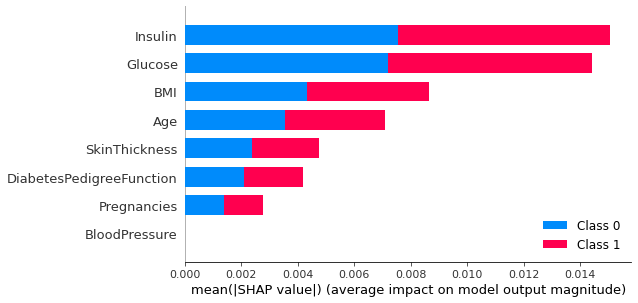

In [239]:
# produce the SHAP values to plot feature importance
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
lgb_explainer = shap.KernelExplainer(pipeline_lgb_final.predict_proba, background)
lgb_shap_values = lgb_explainer.shap_values(X_train)
shap.summary_plot(lgb_shap_values, X_train, show = False, feature_names = df_clean.columns[:-1].values)

The top three relevant features are:
1. Insulin
2. Glucose
3. BMI

This is in line with our data exploration earlier: we saw that Glucose had the highest correletion (in terms of linear association) to the Outcome, and that the Outcome is weakly correlated with Glucose, Insulin, and BMI.

In [44]:
# predict the test data
y_predict_lgb = pipeline_lgb_final.predict_proba(X_test)

# transform the prediction (probability) into a binary variable
y_predict_lgb_binary = np.round(y_predict_lgb[:,1]).astype(int)

# print true value (y_test) and the predicited value
pd.DataFrame({
    'True': y_test,
    'Predicted':     [ row[1] for row in y_predict_lgb],
    'Predicted Binary': y_predict_lgb_binary
})

,True,Predicted,Predicted Binary
0,0,0.469379,0
1,1,0.528348,1
2,1,0.510998,1
3,1,0.475671,0
4,0,0.475671,0
...,...,...,...
145,0,0.502234,1
146,0,0.469379,0
147,0,0.469379,0
148,0,0.517799,1


## 3.2) KNN

Since the project asks us to compare various models with the results from the KNN algorithm, our next model is KNN.

Similar to above, we start with hyperparameter optimization. First, we find the optimal value of the number of neighbors.

In [45]:
# test KNN model with different neighbour values k
avg_score = []
for k in range(2,50):
    knn = KNeighborsClassifier(n_jobs=4, n_neighbors=k)
    pipeline_knn = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('knn', knn)])
    score = cross_val_score(pipeline_knn, X_train, y_train, cv=5, n_jobs=4, scoring='roc_auc')
    avg_score.append(score.mean())

Text(0, 0.5, 'avg_score')

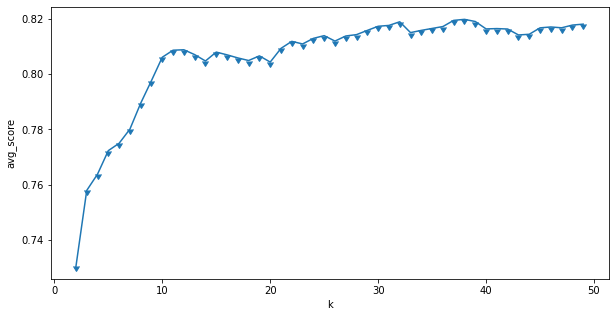

In [46]:
# plot ROC AUC score for the different neighbour values k
plt.plot(range(2,50), avg_score, marker=11)
plt.xlabel('k')
plt.ylabel('ROC AUC score')

The best value for k is 32.

In [47]:
# other KNN hyperparameters
knn_param_test = {'knn_tune__leaf_size': list(range(1,50)),
                  'knn_tune__p': [1, 2],
                  'knn_tune__weights': ['uniform', 'distance']}

In [48]:
# create classifier object for hyperparameter optimization
knn_tune = KNeighborsClassifier(n_jobs=4, n_neighbors=32)

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_knn_tune = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('knn_tune', knn_tune)])

# create GridSearchCV object for hyperparameter optimization
knn_search = GridSearchCV(estimator = pipeline_knn_tune,
                          param_grid = knn_param_test,
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = True,
                          return_train_score = True)

In [49]:
# fit our train data
knn_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(knn_search.best_score_, knn_search.best_params_))

Fitting 5 folds for each of 196 candidates, totalling 980 fits
Best score reached: 0.822826663322013 with params: {'knn_tune__leaf_size': 1, 'knn_tune__p': 1, 'knn_tune__weights': 'distance'} 


Best score reached: 0.822826663322013 with params: {'knn_tune__leaf_size': 1, 'knn_tune__p': 1, 'knn_tune__weights': 'distance'}

In [50]:
# create final pipeline object with the "best" found classifier
pipeline_knn_final = knn_search.best_estimator_

# train the final model
pipeline_knn_final.fit(X_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()),
                ('smt',
                 BorderlineSMOTE(kind='borderline-2', n_jobs=4,
                                 random_state=7)),
                ('knn_tune',
                 KNeighborsClassifier(leaf_size=1, n_jobs=4, n_neighbors=32,
                                      p=1, weights='distance'))])

  0%|          | 0/598 [00:00<?, ?it/s]

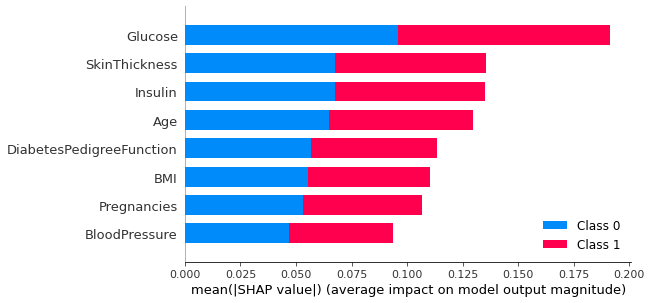

In [77]:
# produce the SHAP values to plot feature importance
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
knn_explainer = shap.KernelExplainer(pipeline_knn_final.predict_proba, background)
knn_shap_values = knn_explainer.shap_values(X_train)
shap.summary_plot(knn_shap_values, X_train, show = False, feature_names = df_clean.columns[:-1].values)

In [80]:
# predict the test data
y_predict_knn = pipeline_knn_final.predict_proba(X_test)

# transform the prediction (probability) into a binary variable
y_predict_knn_binary = np.round(y_predict_knn[:,1]).astype(int)

# print true value (y_test) and the predicited value
pd.DataFrame({
    'True': y_test,
    'Predicted':     [ row[1] for row in y_predict_knn],
    'Predicted Binary': y_predict_knn_binary
})

,True,Predicted,Predicted Binary
0,0,0.222334,0
1,1,0.790380,1
2,1,0.851942,1
3,1,0.579221,1
4,0,0.143065,0
...,...,...,...
145,0,0.824355,1
146,0,0.262175,0
147,0,0.029561,0
148,0,0.732143,1


## 3.3) Compare Various Models (with default parameters)

Now, we evaluate various classification models and compare them via the ROC AUC score by cross-validation. Important to note is that we use the models with their default parameters (except KNN and LGBMClassifier, for which we use the optimal parameters that we found above).

In [81]:
# list of models to evaluate
def get_models():
    models = list()
    models.append(LogisticRegression(max_iter=500))
    models.append(RidgeClassifier())
    models.append(SGDClassifier())
    models.append(PassiveAggressiveClassifier())
    models.append(DecisionTreeClassifier())
    models.append(ExtraTreeClassifier())
    models.append(LinearSVC(tol=0.001))
    models.append(SVC())
    models.append(GaussianNB())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier())
    models.append(RandomForestClassifier())
    models.append(ExtraTreesClassifier())
    models.append(GaussianProcessClassifier())
    models.append(GradientBoostingClassifier())
    models.append(LinearDiscriminantAnalysis())
    models.append(QuadraticDiscriminantAnalysis())
    models.append(lgb.LGBMClassifier(colsample_bytree=0.9568345838497743, learning_rate=0.07, max_bin=130, metric='None',
                                     min_child_samples=30, min_child_weight=0.01, n_estimators=1000, n_jobs=4, num_leaves=47,
                                     objective='binary', random_state=1, reg_alpha=1, reg_lambda=1, 
                                     subsample=0.5324832797276597))
    models.append(KNeighborsClassifier(leaf_size=1, n_jobs=4, n_neighbors=32, p=1, weights='distance'))
    
    return models

In [82]:
# evaluate the model
def evaluate_model(cv, model):
    # create pipeline object with feature scaling, Borderline-SMOTE, and classifier
    pipeline_model = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('model', model)])
    # evaluate the model
    scores = cross_val_score(pipeline_model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=4)
    # return scores
    return scores.mean()

In [84]:
# define test conditions
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# get the list of models
models = get_models()

# collect results
cv_results = list()

# evaluate each model
for model in models:
    # evaluate model using test condition
    cv_mean = evaluate_model(cv, model)
    
    # check for invalid results
    if np.isnan(cv_mean):
        continue
    
    # store results
    cv_results.append(cv_mean)
    
    # summarize progress
    print('>%s: cv=%.3f' % (type(model).__name__, cv_mean))

>LogisticRegression: cv=0.845
>RidgeClassifier: cv=0.844
>SGDClassifier: cv=0.814
>PassiveAggressiveClassifier: cv=0.785
>DecisionTreeClassifier: cv=0.665
>ExtraTreeClassifier: cv=0.646
>LinearSVC: cv=0.843
>SVC: cv=0.823
>GaussianNB: cv=0.842
>AdaBoostClassifier: cv=0.825
>BaggingClassifier: cv=0.805
>RandomForestClassifier: cv=0.827
>ExtraTreesClassifier: cv=0.833
>GaussianProcessClassifier: cv=0.814
>GradientBoostingClassifier: cv=0.843
>LinearDiscriminantAnalysis: cv=0.844
>QuadraticDiscriminantAnalysis: cv=0.831
>LGBMClassifier: cv=0.822
>KNeighborsClassifier: cv=0.818


The top five models with respect to the ROC AUC score are:
1. LogisticRegression: cv=0.845
2. RidgeClassifier: cv=0.844
3. LinearDiscriminantAnalysis: cv=0.844
4. LinearSVC: cv=0.843
5. GradientBoostingClassifier: cv=0.843

Again, I want to emphasize that we did not perform hyperparameter optimization for those models (except LGBMClassifier and KNN), so their performance might be better.

Below, we will do hyperparameter optimization for the top three models (LogisticRegression, RidgeClassifier, LinearDiscriminantAnalysis) and for ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier.

## 3.4) LogisticRegression

In [89]:
# create classifier object for hyperparameter optimization
log_tune = LogisticRegression(max_iter=500)

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_log_tune = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('log_tune', log_tune)])

# create GridSearchCV object for hyperparameter optimization (hyperparameter: solver)
log_search = GridSearchCV(estimator = pipeline_log_tune,
                          param_grid = {'log_tune__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = True,
                          return_train_score = True)

In [90]:
# fit our train data
log_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(log_search.best_score_, log_search.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score reached: 0.8393804414942885 with params: {'log_tune__solver': 'liblinear'} 


Best score reached: 0.8393804414942885 with params: {'log_tune__solver': 'liblinear'} 

In [98]:
# create classifier object for hyperparameter optimization
log_tune = LogisticRegression(max_iter=500, solver='liblinear')

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_log_tune = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('log_tune', log_tune)])

# create GridSearchCV object for hyperparameter optimization (hyperparameter: penalty)
log_search = GridSearchCV(estimator = pipeline_log_tune,
                          param_grid = {'log_tune__penalty': ['l1', 'l2'], 'log_tune__C': [100, 10, 1.0, 0.1, 0.01]},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = True,
                          return_train_score = True)

In [99]:
# fit our train data
log_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(log_search.best_score_, log_search.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score reached: 0.8412955580426058 with params: {'log_tune__C': 0.1, 'log_tune__penalty': 'l2'} 


Best score reached: 0.8412955580426058 with params: {'log_tune__C': 0.1, 'log_tune__penalty': 'l2'} 

In [101]:
# create final pipeline object with the "best" found classifier
pipeline_log_final = log_search.best_estimator_

# train the final model
pipeline_log_final.fit(X_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()),
                ('smt',
                 BorderlineSMOTE(kind='borderline-2', n_jobs=4,
                                 random_state=7)),
                ('log_tune',
                 LogisticRegression(C=0.1, max_iter=500, solver='liblinear'))])

  0%|          | 0/598 [00:00<?, ?it/s]

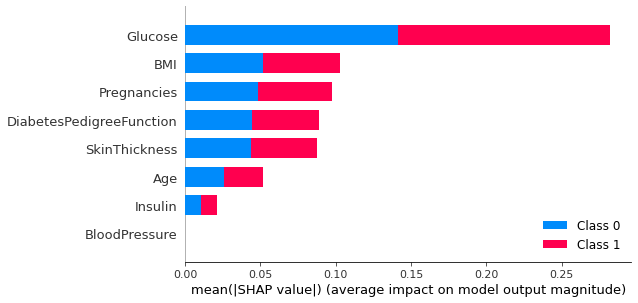

In [102]:
# produce the SHAP values to plot feature importance
log_explainer = shap.KernelExplainer(pipeline_log_final.predict_proba, background)
log_shap_values = log_explainer.shap_values(X_train)
shap.summary_plot(log_shap_values, X_train, show = False, feature_names = df_clean.columns[:-1].values)

In [158]:
# predict the test data
y_predict_log = pipeline_log_final.predict_proba(X_test)

# transform the prediction (probability) into a binary variable
y_predict_log_binary = np.round(y_predict_log[:,1]).astype(int)

# print true value (y_test) and the predicited value
pd.DataFrame({
    'True': y_test,
    'Predicted':     [ row[1] for row in y_predict_log],
    'Predicted Binary': y_predict_log_binary
})

,True,Predicted,Predicted Binary
0,0,0.180489,0
1,1,0.936087,1
2,1,0.845098,1
3,1,0.386515,0
4,0,0.170848,0
...,...,...,...
145,0,0.905249,1
146,0,0.181938,0
147,0,0.112282,0
148,0,0.518981,1


## 3.5) RidgeClassifier

In [105]:
# hyperparameters
ridge_param_test = {'ridge_tune__class_weight': ['balanced', None],
                    'ridge_tune__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

In [106]:
# create classifier object for hyperparameter optimization
ridge_tune = RidgeClassifier()

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_ridge_tune = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('ridge_tune', ridge_tune)])

# create GridSearchCV object for hyperparameter optimization
ridge_search = GridSearchCV(estimator = pipeline_ridge_tune,
                          param_grid = ridge_param_test,
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = True,
                          return_train_score = True)

In [107]:
# fit our train data
ridge_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(ridge_search.best_score_, ridge_search.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score reached: 0.8393773155294845 with params: {'ridge_tune__alpha': 0.8, 'ridge_tune__class_weight': 'balanced'} 


Best score reached: 0.8393773155294845 with params: {'ridge_tune__alpha': 0.8, 'ridge_tune__class_weight': 'balanced'}

In [108]:
# create final pipeline object with the "best" found classifier
pipeline_ridge_final = ridge_search.best_estimator_

# train the final model
pipeline_ridge_final.fit(X_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()),
                ('smt',
                 BorderlineSMOTE(kind='borderline-2', n_jobs=4,
                                 random_state=7)),
                ('ridge_tune',
                 RidgeClassifier(alpha=0.8, class_weight='balanced'))])

  0%|          | 0/598 [00:00<?, ?it/s]

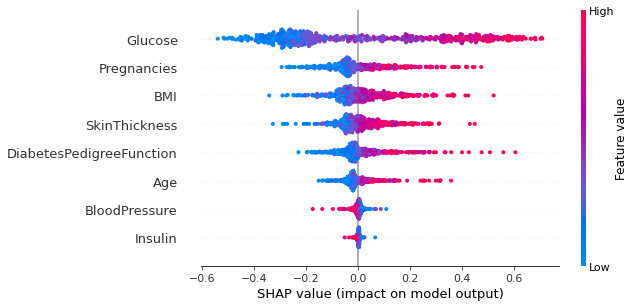

In [146]:
# produce the SHAP values to plot feature importance
ridge_explainer = shap.KernelExplainer(pipeline_ridge_final.predict, background)
ridge_shap_values = ridge_explainer.shap_values(X_train)
shap.summary_plot(ridge_shap_values, X_train, show = False, feature_names = df_clean.columns[:-1].values)

In [204]:
# predict the test data
y_predict_ridge = pipeline_ridge_final.predict(X_test)

# transform the prediction (probability) into a binary variable
y_predict_ridge_binary = y_predict_ridge
y_predict_ridge = np.array([y_predict_ridge_binary, y_predict_ridge_binary]).transpose()

# print true value (y_test) and the predicited value
pd.DataFrame({
    'True': y_test,
    'Predicted Binary': y_predict_ridge_binary
})

,True,Predicted Binary
0,0,0
1,1,1
2,1,1
3,1,0
4,0,0
...,...,...
145,0,1
146,0,0
147,0,0
148,0,1


## 3.6) LinearDiscriminantAnalysis

In [147]:
# create classifier object for hyperparameter optimization
lda_tune = LinearDiscriminantAnalysis()

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_lda_tune = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('lda_tune', lda_tune)])

# create GridSearchCV object for hyperparameter optimization (hyperparameter: solver)
lda_search = GridSearchCV(estimator = pipeline_lda_tune,
                          param_grid = {'lda_tune__solver': ['svd', 'lsqr', 'eigen']},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = True,
                          return_train_score = True)

In [148]:
# fit our train data
lda_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(lda_search.best_score_, lda_search.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score reached: 0.8391889857980859 with params: {'lda_tune__solver': 'svd'} 


Best score reached: 0.8391889857980859 with params: {'lda_tune__solver': 'svd'}

In [149]:
# create final pipeline object with the "best" found classifier
pipeline_lda_final = lda_search.best_estimator_

# train the final model
pipeline_lda_final.fit(X_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()),
                ('smt',
                 BorderlineSMOTE(kind='borderline-2', n_jobs=4,
                                 random_state=7)),
                ('lda_tune', LinearDiscriminantAnalysis())])

  0%|          | 0/598 [00:00<?, ?it/s]

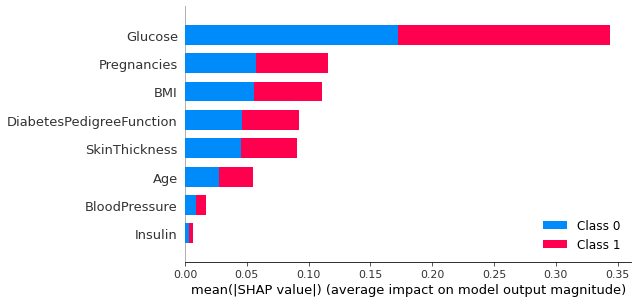

In [153]:
# produce the SHAP values to plot feature importance
lda_explainer = shap.KernelExplainer(pipeline_lda_final.predict_proba, background)
lda_shap_values = lda_explainer.shap_values(X_train)
shap.summary_plot(lda_shap_values, X_train, show = False, feature_names = df_clean.columns[:-1].values)

In [160]:
# predict the test data
y_predict_lda = pipeline_lda_final.predict_proba(X_test)

# transform the prediction (probability) into a binary variable
y_predict_lda_binary = np.round(y_predict_lda[:,1]).astype(int)

# print true value (y_test) and the predicited value
pd.DataFrame({
    'True': y_test,
    'Predicted':     [ row[1] for row in y_predict_lda],
    'Predicted Binary': y_predict_lda_binary
})

,True,Predicted,Predicted Binary
0,0,0.128995,0
1,1,0.950757,1
2,1,0.852713,1
3,1,0.379060,0
4,0,0.136285,0
...,...,...,...
145,0,0.937575,1
146,0,0.130616,0
147,0,0.089117,0
148,0,0.519744,1


## 3.7) ExtraTreesClassifier

In [219]:
# create classifier object for hyperparameter optimization
extratree_tune = ExtraTreesClassifier(n_jobs=4)

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_extratree_tune = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('extratree_tune', extratree_tune)])

# create GridSearchCV object for hyperparameter optimization (hyperparameter: n_estimators)
extratree_search = GridSearchCV(estimator = pipeline_extratree_tune,
                                param_grid = {'extratree_tune__n_estimators': [10, 50, 100, 500, 1000, 5000]},
                                scoring = 'roc_auc',
                                cv = 5,
                                refit = True,
                                verbose = True,
                                return_train_score = True)

In [220]:
# fit our train data
extratree_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(extratree_search.best_score_, extratree_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score reached: 0.8446993477925286 with params: {'extratree_tune__n_estimators': 500} 


Best score reached: 0.8446993477925286 with params: {'extratree_tune__n_estimators': 500} 

In [221]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: max_depth)
extratree_search = GridSearchCV(estimator = pipeline_extratree_tune,
                                param_grid = {'extratree_tune__max_depth': [5, 20, 50, 100, None]},
                                scoring = 'roc_auc',
                                cv = 5,
                                refit = True,
                                verbose = True,
                                return_train_score = True)

In [222]:
# fit our train data
extratree_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(extratree_search.best_score_, extratree_search.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score reached: 0.8560732865081816 with params: {'extratree_tune__max_depth': 5} 


Best score reached: 0.8560732865081816 with params: {'extratree_tune__max_depth': 5}

In [223]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: min_samples_split)
extratree_search = GridSearchCV(estimator = pipeline_extratree_tune,
                                param_grid = {'extratree_tune__min_samples_split': [2, 5, 10, 20]},
                                scoring = 'roc_auc',
                                cv = 5,
                                refit = True,
                                verbose = True,
                                return_train_score = True)

In [224]:
# fit our train data
extratree_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(extratree_search.best_score_, extratree_search.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best score reached: 0.8508163978079655 with params: {'extratree_tune__min_samples_split': 20} 


Best score reached: 0.8508163978079655 with params: {'extratree_tune__min_samples_split': 20}

In [225]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: min_samples_leaf)
extratree_search = GridSearchCV(estimator = pipeline_extratree_tune,
                                param_grid = {'extratree_tune__min_samples_leaf': [1, 2, 5, 10, 25, 50]},
                                scoring = 'roc_auc',
                                cv = 5,
                                refit = True,
                                verbose = True,
                                return_train_score = True)

In [226]:
# fit our train data
extratree_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(extratree_search.best_score_, extratree_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score reached: 0.8546447398888546 with params: {'extratree_tune__min_samples_leaf': 25} 


Best score reached: 0.8546447398888546 with params: {'extratree_tune__min_samples_leaf': 25}

In [227]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: bootstrap)
extratree_search = GridSearchCV(estimator = pipeline_extratree_tune,
                                param_grid = {'extratree_tune__bootstrap': [True, False]},
                                scoring = 'roc_auc',
                                cv = 5,
                                refit = True,
                                verbose = True,
                                return_train_score = True)

In [228]:
# fit our train data
extratree_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(extratree_search.best_score_, extratree_search.best_params_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score reached: 0.8442473178450138 with params: {'extratree_tune__bootstrap': False} 


Best score reached: 0.8442473178450138 with params: {'extratree_tune__bootstrap': False}

In [229]:
# create final classifier object
extratree_tune = ExtraTreesClassifier(n_jobs=4, n_estimators=500, max_depth=5, min_samples_split=20,
                                       min_samples_leaf=25, bootstrap=False)

# create final pipeline object with the "best" found classifier
pipeline_extratree_final = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('extratree_tune', extratree_tune)])

# train the final model
pipeline_extratree_final.fit(X_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()),
                ('smt',
                 BorderlineSMOTE(kind='borderline-2', n_jobs=4,
                                 random_state=7)),
                ('extratree_tune',
                 ExtraTreesClassifier(max_depth=5, min_samples_leaf=25,
                                      min_samples_split=20, n_estimators=500,
                                      n_jobs=4))])

  0%|          | 0/598 [00:00<?, ?it/s]

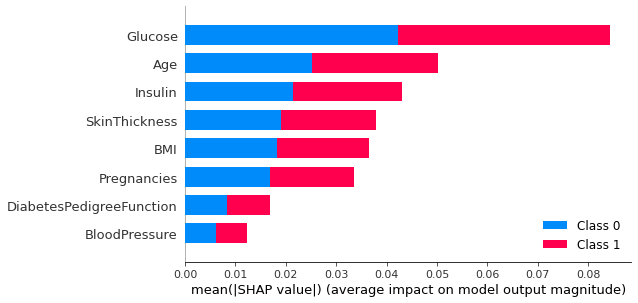

In [238]:
# produce the SHAP values to plot feature importance
extratree_explainer = shap.KernelExplainer(pipeline_extratree_final.predict_proba, background)
extratree_shap_values = extratree_explainer.shap_values(X_train)
shap.summary_plot(extratree_shap_values, X_train, show = False, feature_names = df_clean.columns[:-1].values)

In [230]:
# predict the test data
y_predict_extratree = pipeline_extratree_final.predict_proba(X_test)

# transform the prediction (probability) into a binary variable
y_predict_extratree_binary = np.round(y_predict_extratree[:,1]).astype(int)

# print true value (y_test) and the predicited value
pd.DataFrame({
    'True': y_test,
    'Predicted':     [ row[1] for row in y_predict_extratree],
    'Predicted Binary': y_predict_extratree_binary
})

,True,Predicted,Predicted Binary
0,0,0.384944,0
1,1,0.626813,1
2,1,0.596554,1
3,1,0.482307,0
4,0,0.361378,0
...,...,...,...
145,0,0.635049,1
146,0,0.378759,0
147,0,0.286795,0
148,0,0.547672,1


## 3.8) RandomForestClassifier

In [246]:
# create classifier object for hyperparameter optimisation
forest_tune = RandomForestClassifier(n_jobs=4)

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_forest_tune = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('forest_tune', forest_tune)])

# create GridSearchCV object for hyperparameter optimization (hyperparameter: n_estimators)
forest_search = GridSearchCV(estimator = pipeline_forest_tune,
                             param_grid = {'forest_tune__n_estimators': [10, 50, 100, 500, 1000, 5000]},
                             scoring = 'roc_auc',
                             cv = 5,
                             refit = True,
                             verbose = True,
                             return_train_score = True)

In [247]:
# fit our train data
forest_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(forest_search.best_score_, forest_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score reached: 0.8364462604198828 with params: {'forest_tune__n_estimators': 100} 


Best score reached: 0.8364462604198828 with params: {'forest_tune__n_estimators': 100} 

In [248]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: max_depth)
forest_search = GridSearchCV(estimator = pipeline_forest_tune,
                             param_grid = {'forest_tune__max_depth': [5, 20, 50, 100, None]},
                             scoring = 'roc_auc',
                             cv = 5,
                             refit = True,
                             verbose = True,
                             return_train_score = True)

In [249]:
# fit our train data
forest_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(forest_search.best_score_, forest_search.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score reached: 0.8386622414325411 with params: {'forest_tune__max_depth': 5} 


Best score reached: 0.8386622414325411 with params: {'forest_tune__max_depth': 5} 

In [250]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: min_samples_split)
forest_search = GridSearchCV(estimator = pipeline_forest_tune,
                             param_grid = {'forest_tune__min_samples_split': [2, 5, 10, 15, 20, 25]},
                             scoring = 'roc_auc',
                             cv = 5,
                             refit = True,
                             verbose = True,
                             return_train_score = True)

In [251]:
# fit our train data
forest_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(forest_search.best_score_, forest_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score reached: 0.8346702589533808 with params: {'forest_tune__min_samples_split': 5} 


Best score reached: 0.8346702589533808 with params: {'forest_tune__min_samples_split': 5}

In [252]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: min_samples_leaf)
forest_search = GridSearchCV(estimator = pipeline_forest_tune,
                             param_grid = {'forest_tune__min_samples_leaf': [1, 2, 5, 10, 20, 30, 50]},
                             scoring = 'roc_auc',
                             cv = 5,
                             refit = True,
                             verbose = True,
                             return_train_score = True)

In [253]:
# fit our train data
forest_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(forest_search.best_score_, forest_search.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best score reached: 0.8363389549243594 with params: {'forest_tune__min_samples_leaf': 20} 


Best score reached: 0.8363389549243594 with params: {'forest_tune__min_samples_leaf': 20} 

In [254]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: bootstrap)
forest_search = GridSearchCV(estimator = pipeline_forest_tune,
                             param_grid = {'forest_tune__bootstrap': [True, False]},
                             scoring = 'roc_auc',
                             cv = 5,
                             refit = True,
                             verbose = True,
                             return_train_score = True)

In [255]:
# fit our train data
forest_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(forest_search.best_score_, forest_search.best_params_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score reached: 0.8273601227230628 with params: {'forest_tune__bootstrap': True} 


Best score reached: 0.8273601227230628 with params: {'forest_tune__bootstrap': True} 

In [256]:
# create final classifier object
forest_final = RandomForestClassifier(n_jobs=4, n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=20, 
                                      bootstrap=True)

# create final pipeline object with the "best" found classifier
pipeline_forest_final = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('forest_tune', forest_final)])

# train the final model
pipeline_forest_final.fit(X_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()),
                ('smt',
                 BorderlineSMOTE(kind='borderline-2', n_jobs=4,
                                 random_state=7)),
                ('forest_tune',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=20,
                                        min_samples_split=5, n_jobs=4))])

  0%|          | 0/598 [00:00<?, ?it/s]

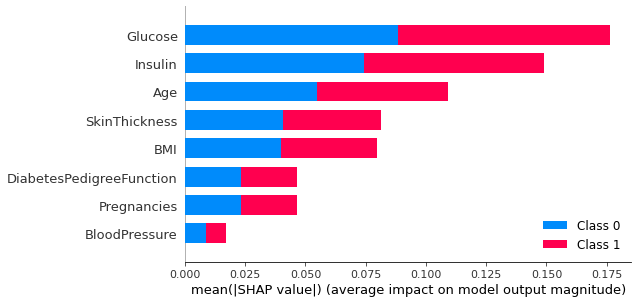

In [257]:
# produce the SHAP values to plot feature importance
forest_explainer = shap.KernelExplainer(pipeline_forest_final.predict_proba, background)
forest_shap_values = forest_explainer.shap_values(X_train)
shap.summary_plot(forest_shap_values, X_train, show = False, feature_names = df_clean.columns[:-1].values)

In [258]:
# predict the test data
y_predict_forest = pipeline_forest_final.predict_proba(X_test)

# transform the prediction (probability) into a binary variable
y_predict_forest_binary = np.round(y_predict_forest[:,1]).astype(int)

# print true value (y_test) and the predicited value
pd.DataFrame({
    'True': y_test,
    'Predicted':     [ row[1] for row in y_predict_forest],
    'Predicted Binary': y_predict_forest_binary
})

,True,Predicted,Predicted Binary
0,0,0.227858,0
1,1,0.703040,1
2,1,0.622825,1
3,1,0.400011,0
4,0,0.163938,0
...,...,...,...
145,0,0.783071,1
146,0,0.196847,0
147,0,0.067750,0
148,0,0.724535,1


## 3.9) GradientBoostingClassifier

In [259]:
# create GradientBoostingClassifier object for hyperparameter optimization
gb_tune = GradientBoostingClassifier()

# create pipeline object with feature scaling, Borderline-SMOTE, and classifier
pipeline_gb_tune = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('gb_tune', gb_tune)])

# create GridSearchCV object for hyperparameter optimization (hyperparameter: n_estimators)
gb_search = GridSearchCV(estimator = pipeline_gb_tune,
                         param_grid = {'gb_tune__n_estimators': [10, 50, 100, 500, 1000, 5000]},
                         scoring = 'roc_auc',
                         cv = 5,
                         refit = True,
                         verbose = True,
                         return_train_score = True)

# fit our train data
gb_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(gb_search.best_score_, gb_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score reached: 0.8349045037048473 with params: {'gb_tune__n_estimators': 50} 


Best score reached: 0.8349045037048473 with params: {'gb_tune__n_estimators': 50} 

In [260]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: max_depth)
gb_search = GridSearchCV(estimator = pipeline_gb_tune,
                         param_grid = {'gb_tune__max_depth': [3, 5, 10, 20, 30]},
                         scoring = 'roc_auc',
                         cv = 5,
                         refit = True,
                         verbose = True,
                         return_train_score = True)

# fit our train data
gb_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(gb_search.best_score_, gb_search.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score reached: 0.8279564101574561 with params: {'gb_tune__max_depth': 3} 


Best score reached: 0.8279564101574561 with params: {'gb_tune__max_depth': 3} 

In [261]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: learning_rate)
gb_search = GridSearchCV(estimator = pipeline_gb_tune,
                         param_grid = {'gb_tune__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.5, 0.7, 1.0]},
                         scoring = 'roc_auc',
                         cv = 5,
                         refit = True,
                         verbose = True,
                         return_train_score = True)

# fit our train data
gb_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(gb_search.best_score_, gb_search.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best score reached: 0.8426258104353195 with params: {'gb_tune__learning_rate': 0.03} 


Best score reached: 0.8426258104353195 with params: {'gb_tune__learning_rate': 0.03} 

In [262]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: subsample)
gb_search = GridSearchCV(estimator = pipeline_gb_tune,
                         param_grid = {'gb_tune__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
                         scoring = 'roc_auc',
                         cv = 5,
                         refit = True,
                         verbose = True,
                         return_train_score = True)

# fit our train data
gb_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(gb_search.best_score_, gb_search.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score reached: 0.8402913322012967 with params: {'gb_tune__subsample': 0.6} 


Best score reached: 0.8402913322012967 with params: {'gb_tune__subsample': 0.6}

In [263]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: min_samples_split)
gb_search = GridSearchCV(estimator = pipeline_gb_tune,
                         param_grid = {'gb_tune__min_samples_split': [2, 5, 10, 15, 20, 25]},
                         scoring = 'roc_auc',
                         cv = 5,
                         refit = True,
                         verbose = True,
                         return_train_score = True)

# fit our train data
gb_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(gb_search.best_score_, gb_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score reached: 0.8300077377276937 with params: {'gb_tune__min_samples_split': 5} 


Best score reached: 0.8300077377276937 with params: {'gb_tune__min_samples_split': 5} 

In [264]:
# create GridSearchCV object for hyperparameter optimization (hyperparameter: min_samples_leaf)
gb_search = GridSearchCV(estimator = pipeline_gb_tune,
                         param_grid = {'gb_tune__min_samples_leaf': [1, 2, 5, 10, 20, 30, 50]},
                         scoring = 'roc_auc',
                         cv = 5,
                         refit = True,
                         verbose = True,
                         return_train_score = True)

# fit our train data
gb_search.fit(X_train, y_train)

# print best parameter values
print('Best score reached: {} with params: {} '.format(gb_search.best_score_, gb_search.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best score reached: 0.8332656298240197 with params: {'gb_tune__min_samples_leaf': 30} 


Best score reached: 0.8332656298240197 with params: {'gb_tune__min_samples_leaf': 30} 

In [265]:
# create final classifier object
gb_final = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.03, subsample=0.6, 
                                      min_samples_split=5, min_samples_leaf=30)

# create final pipeline object with the "best" found classifier
pipeline_gb_final = Pipeline(steps=[('transformer', transformer), ('smt', smt), ('gb_tune', gb_final)])

# train the final model
pipeline_gb_final.fit(X_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()),
                ('smt',
                 BorderlineSMOTE(kind='borderline-2', n_jobs=4,
                                 random_state=7)),
                ('gb_tune',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            min_samples_leaf=30,
                                            min_samples_split=5,
                                            n_estimators=50, subsample=0.6))])

  0%|          | 0/598 [00:00<?, ?it/s]

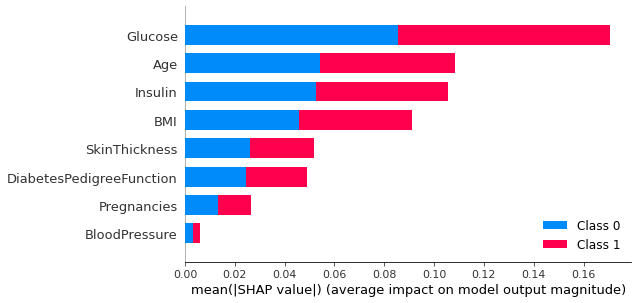

In [266]:
# produce the SHAP values to plot feature importance
gb_explainer = shap.KernelExplainer(pipeline_gb_final.predict_proba, background)
gb_shap_values = gb_explainer.shap_values(X_train)
shap.summary_plot(gb_shap_values, X_train, show = False, feature_names = df_clean.columns[:-1].values)

In [267]:
# predict the test data
y_predict_gb = pipeline_gb_final.predict_proba(X_test)

# transform the prediction (probability) into a binary variable
y_predict_gb_binary = np.round(y_predict_gb[:,1]).astype(int)

# print true value (y_test) and the predicited value
pd.DataFrame({
    'True': y_test,
    'Predicted':     [ row[1] for row in y_predict_gb],
    'Predicted Binary': y_predict_gb_binary
})

,True,Predicted,Predicted Binary
0,0,0.251134,0
1,1,0.704520,1
2,1,0.513781,1
3,1,0.373241,0
4,0,0.174920,0
...,...,...,...
145,0,0.689070,1
146,0,0.215541,0
147,0,0.134052,0
148,0,0.700653,1


## 3.10) Comparison of the Selected Models

In [268]:
# our selected models in a list
models = [
    ('LightGBM', pipeline_lgb_final, 'lgb'),
    ('KNN', pipeline_knn_final, 'knn'),
    ('LogisticRegression', pipeline_log_final, 'log'),
    ('RidgeClassifier', pipeline_ridge_final, 'ridge'),
    ('LDA', pipeline_lda_final, 'lda'),
    ('ExtraTreesClassifier', pipeline_extratree_final, 'extratree'),
    ('RandomForestClassifier', pipeline_forest_final, 'forest'),
    ('GradientBoostingClassifier', pipeline_gb_final, 'gb')
]

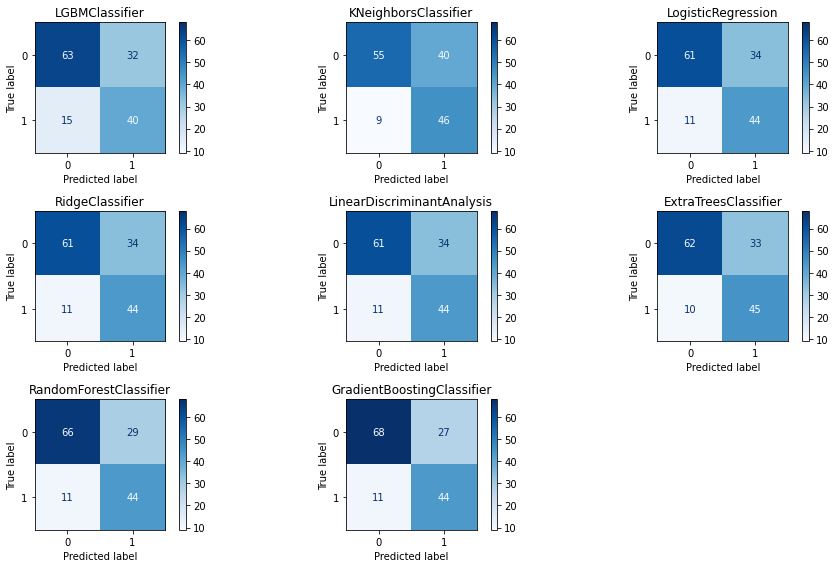

In [274]:
# confusion matrices

# regular expression to extract the name from the model for the subplot titles below
reg_exp = re.compile("(.*?)\s*\(")

# plot confusion matrix for each model
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13,8))
for model, ax in zip([a_tuple[1] for a_tuple in models], axes.flatten()):
    metrics.plot_confusion_matrix(model, X_test, y_test, ax=ax, cmap='Blues')
    ax.title.set_text(reg_exp.match(str(model[2])).group(1))
    ax.get_images()[0].set_clim(9, 68)
plt.tight_layout()
fig.delaxes(axes[2,2])
plt.show()

In [275]:
# classification reports
for name, _, model in models:
    print(name)
    print(metrics.classification_report(y_test,eval('y_predict_' + model + '_binary')))

LightGBM
              precision    recall  f1-score   support

           0       0.81      0.66      0.73        95
           1       0.56      0.73      0.63        55

    accuracy                           0.69       150
   macro avg       0.68      0.70      0.68       150
weighted avg       0.72      0.69      0.69       150

KNN
              precision    recall  f1-score   support

           0       0.86      0.58      0.69        95
           1       0.53      0.84      0.65        55

    accuracy                           0.67       150
   macro avg       0.70      0.71      0.67       150
weighted avg       0.74      0.67      0.68       150

LogisticRegression
              precision    recall  f1-score   support

           0       0.85      0.64      0.73        95
           1       0.56      0.80      0.66        55

    accuracy                           0.70       150
   macro avg       0.71      0.72      0.70       150
weighted avg       0.74      0.70      0.7

We have:
- True negative (TN): Healthy correctly identified as healthy (class 0 correctly identified as class 0)
- False positive (FP): Healthy incorrectly identified as diabetic (class 0 incorrectly identified as class 1)
- False negative (FN): Diabetic incorrectly identified as healthy (class 1 incorrectly identified as class 0)
- True positive (TP): Diabetic correctly identified as diabetic (class 1 correctly identified as class 1)

The more severe error is related to FN, so it's the Type II error which is calculated as 1-recall. The Type II errors are as follows:
- KNN: 0.16
- ExtraTreesClassifier: 0.18
- LogisticRegression: 0.2
- RidgeClassifier: 0.2
- LDA: 0.2
- RandomForestClassifier: 0.2
- GradientBoostingClassifier: 0.2
- LightGBM: 0.27

KNN has the lowest Type II error, while LightGBM has the highest.

The accuracy scores are as follows:
- GradientBoostingClassifier: 0.75
- RandomForestClassifier: 0.73
- ExtraTreesClassifier: 0.71
- LogisticRegression: 0.70
- RidgeClassifier: 0.70
- LDA: 0.70
- LightGBM: 0.69
- KNN: 0.67

GradientBoostingClassifier has the highest accuracy score, while KNN has the lowest. Our test data contains 95 entries from Outcome class 0 and 55 entries from Outcome class 1. Accuracy can be a misleading metric for imbalanced data sets.

The f1-score combines precision and recall into one metric. This metric is used when we care more about the positive class. The f1-scores are as follows:
- GradientBoostingClassifier: 0.70
- RandomForestClassifier: 0.69
- ExtraTreesClassifier: 0.68
- LogisticRegression: 0.66
- RidgeClassifier: 0.66
- LDA: 0.66
- KNN: 0.65
- LightGBM: 0.63

GradientBoostingClassifier has the highest f1-score, while LightGBM has the lowest.

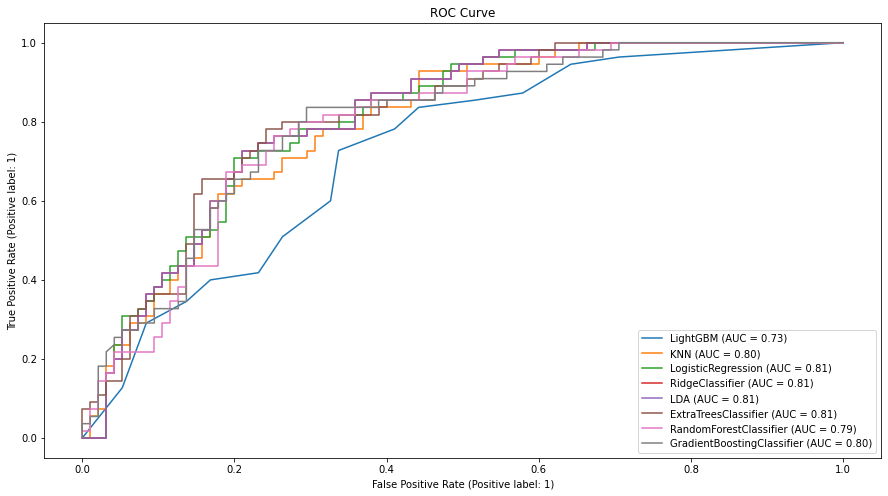

In [269]:
# ROC Curves and AUCs
fig, ax = plt.subplots(figsize=(15,8))

model_displays = {}
for name, model, _ in models:
    model_displays[name] = metrics.plot_roc_curve(model, X_test, y_test, ax=ax, name=name)
_ = ax.set_title('ROC Curve')

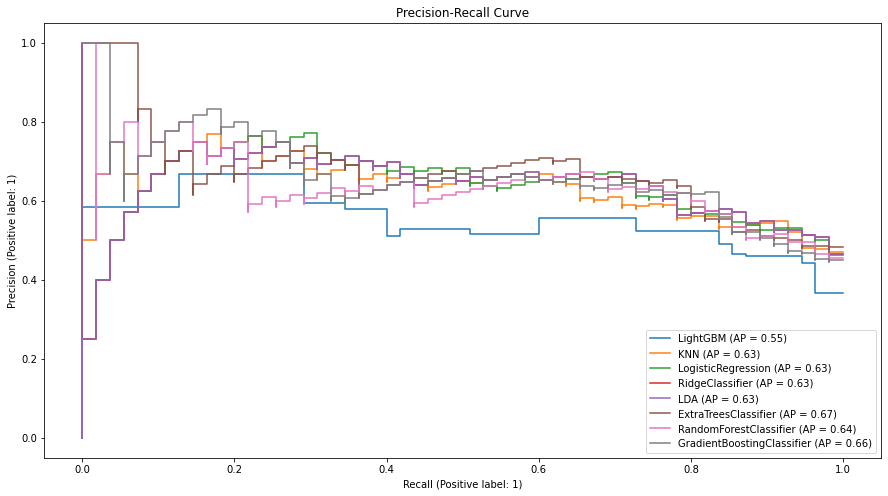

In [270]:
# Precision-Recall curves and APs
fig, ax = plt.subplots(figsize=(15,8))

model_displays = {}
for name, model, _ in models:
    model_displays[name] = metrics.plot_precision_recall_curve(model, X_test, y_test, ax=ax, name=name)
_ = ax.set_title('Precision-Recall Curve')
plt.legend(loc='lower right')

If we care equally about the positive and negative class or your dataset is quite balanced, then going with ROC AUC is a good idea. But if our dataset is heavily imbalanced we should rather consider the Precision-Recall curve and PR AUC (average precision [AP] scores).

The AP scores are as follows:
- ExtraTreesClassifier: 0.67
- GradientBoostingClassifier: 0.66
- RandomForestClassifier: 0.64
- LogisticRegression: 0.63
- RidgeClassifier: 0.63
- LDA: 0.63
- KNN: 0.63
- LightGBM: 0.55

Overall, the GradientBoostingClassifier seems to be the best model: Its Type II error is 0.2 (which is the same for most of the above models), and it has the best accuracy score and f1-score among the above models.

We plotted the feature importance further above. The top features are:
1. Glucose
2. Age
3. Insulin
4. BMI
5. SkinThickness
6. DiabetesPedigreeFunction
7. Pregnancies
8. BloodPressure

which makes sense. Diabetes occurs when the blood glucose (blood sugar) is too high. BMI has a strong relationship to diabetes and insulin resistance. The risk of type 2 diabetes increases as we get older, especially after age 45. The risk of developing type 2 diabetes increases if women developed gestational diabetes when they were pregnant or if they gave birth to a baby weighing more than 9 pounds. [https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes/type-2-diabetes] [https://www.mayoclinic.org/diseases-conditions/type-2-diabetes/symptoms-causes/syc-20351193] [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4259868/#:~:text=Body%20mass%20index%20has%20a,of%20insulin%20resistance%2C%20is%20increased.]

<br>

# 4) Data Reporting

Create a dashboard in tableau by choosing appropriate chart types and metrics useful for the business. The dashboard must entail the following:

1. Pie chart to describe the diabetic or non-diabetic population


2. Scatter charts between relevant variables to analyze the relationships


3. Histogram or frequency charts to analyze the distribution of the data


4. Heatmap of correlation analysis among the relevant variables


5. Create bins of these age values: 20-25, 25-30, 30-35, etc. Analyze different variables for these age brackets using a bubble chart.

You can find the dashboard at 
<a href="https://public.tableau.com/views/ProjectHealthcarePGP/HealthcareDashboard?:language=en-US&:display_count=n&:origin=viz_share_link" target="_blank">https://public.tableau.com/views/ProjectHealthcarePGP/HealthcareDashboard?:language=en-US&:display_count=n&:origin=viz_share_link</a>.

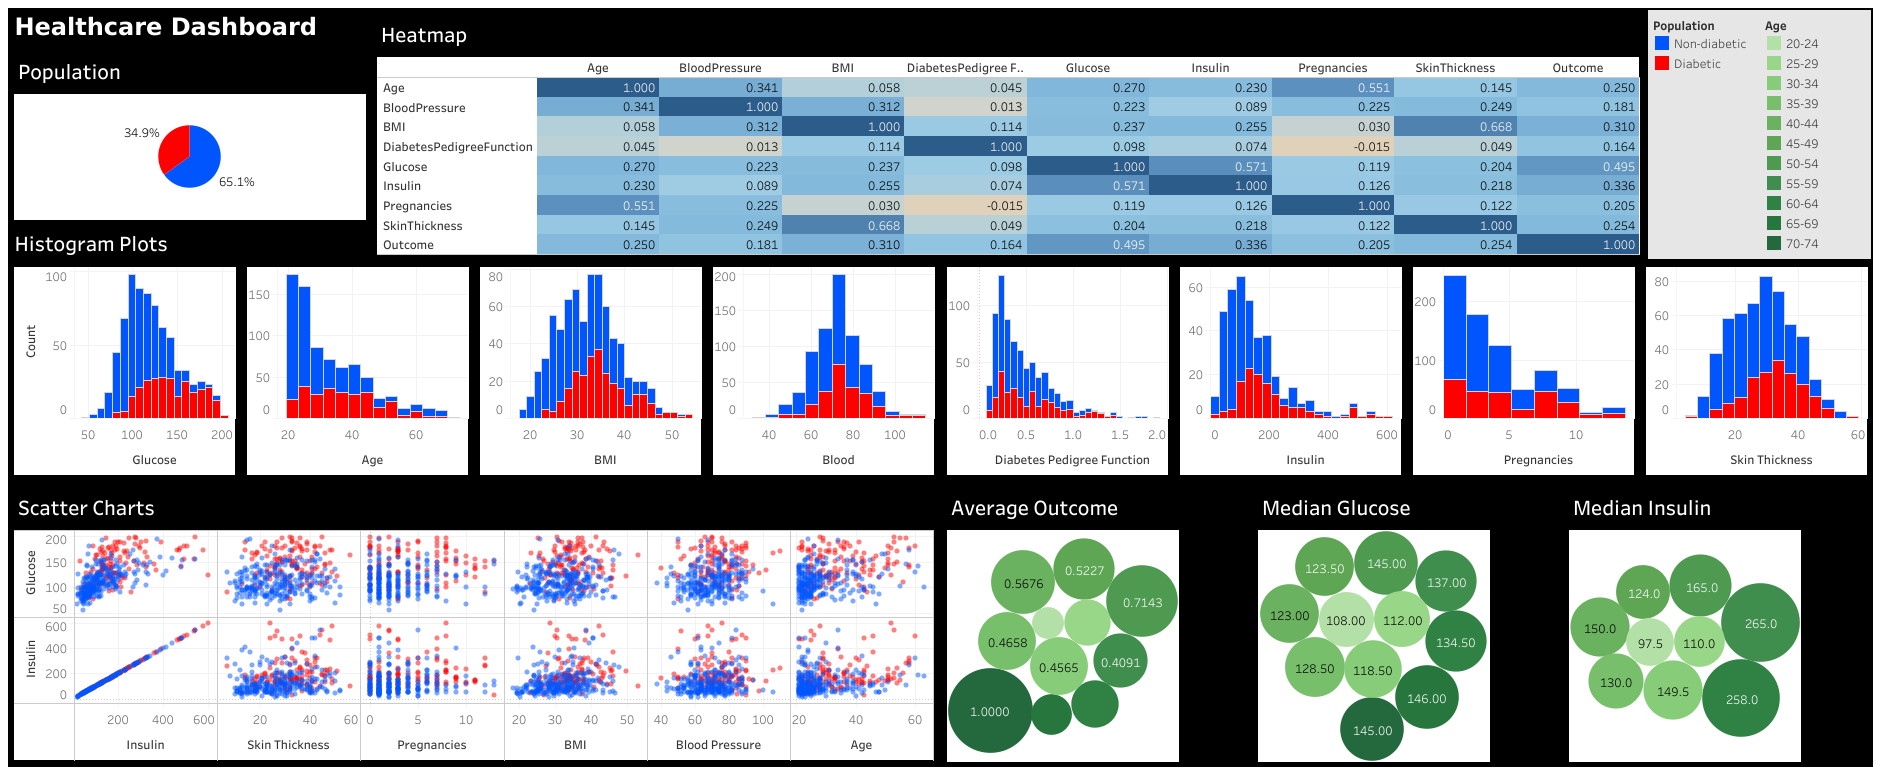

In [1]:
from IPython import display
display.Image('images/Healthcare Dashboard.png')

The population chart, heatmap, histogram plots, and scatter charts are in accordance with our data analysis we did above.

The three bubble charts show the Average of Outcome, Median of Glucose, and Median of Insulin for the different bins of age values 20-24, 25-29, 30-34, and so on. Each bubble represents a bin of age values. The larger a bubble is, the larger is the Average of Outcome/Median of Glucose/Median of Insulin.

Average of Outcome: The Average of Outcome is mostly increasing with increasing age values, meaning that the incidence of diabetes increases as we get older.

Median of Glucose: The Median of Glucose is mostly increasing with increasing age values, meaning that blood glucose levels increase as we get older.

Median of Insulin: The Median of Insulin is mostly increasing with increasing age values, meaning that insulin levels increase as we get older.